In [1]:
%load_ext autoreload
%autoreload 2
# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

In [2]:
import torch
from torch import nn
from torch.nn.init import calculate_gain
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f'CUDA {i}: {torch.cuda.get_device_name(i)}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

CUDA 0: NVIDIA GeForce GTX 1650 Ti


In [3]:
from models import MLP_GPINN, G_PINN, LambdaAdaptive, MLP_GPINN_LambdaAdaptive, Davies2021
#net = MLP_gPINN(N_layers=8, width=32, loss_lambda=(1.0, 1.0, 0.0), activation=nn.ELU()).to(device)
#print(isinstance(net, LambdaAdaptive))

net = MLP_GPINN(N_layers=8, width=32, loss_lambda=(1.0, 3.0, 0.01), activation=nn.ELU()).to(device)

In [4]:
import os
from utils.dataset import ImplicitDataset, RandomMeshSDFDataset

dataset_name = '../datasets/box_1f0_gyroid_4pi'
output_stl = dataset_name+'.stl'
#train_dataset = ImplicitDataset.from_file(file=dataset_name+'_train.npz', device=device)
train_dataset = RandomMeshSDFDataset(output_stl, sampling_method='importance', M=int(1e6), W=10, device=device)
print(train_dataset)

use_random_sdf = isinstance(train_dataset, RandomMeshSDFDataset)
points = train_dataset.points if use_random_sdf else train_dataset.pde_points
sdfs = train_dataset.sdfs if use_random_sdf else train_dataset.bc_sdfs

RandomMeshSDFDataset (10000 points)


In [5]:
from utils.optimizer import CallbackScheduler

# Optimization
## ADA
optimizer=torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-6, amsgrad=False)
lr_scheduler = CallbackScheduler([
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.init_LBFGS(
        lr=1, max_iter=20, max_eval=40, 
        tolerance_grad=1e-5, tolerance_change=1e-9,
        history_size=100,
        line_search_fn=None
    ),
    CallbackScheduler.reduce_lr(0.2)
], optimizer=optimizer, model=net, eps=1e-7, patience=300)

In [8]:
#torch.autograd.set_detect_anomaly(True)
max_epochs = 2500
PRINT_EVERY_EPOCH = 100
points.requires_grad_(True)
try:
    for epoch in range(max_epochs):
        # Training
        optimizer.zero_grad()
        y = net(points)
        loss = net.loss(y, points, points, sdfs)
        loss.backward(retain_graph=True)
      
        lr_scheduler.optimizer.step(lambda: loss)
        lr_scheduler.step_when((epoch % 500) == 499)
        lr_scheduler.step_loss(loss)
        
        if epoch % PRINT_EVERY_EPOCH == 0:
            print(f'#{epoch} Loss: {net._loss_PDE:.6f}, {net._loss_SDF:.6f}, {net._loss_gradient_PDE:.6f}')
except KeyboardInterrupt as e:
    print('Bye bye')


#0 Loss: 9.913674, 0.772908, 1.000000
#100 Loss: 0.100950, 0.023660, 1.000000
#200 Loss: 0.043885, 0.018546, 1.000000
#300 Loss: 0.027467, 0.017507, 1.000000
#400 Loss: 0.022883, 0.017737, 1.000000
#500 Loss: 0.020696, 0.017840, 1.000000
#600 Loss: 0.020354, 0.017851, 1.000000
#700 Loss: 0.020055, 0.017854, 1.000000
#800 Loss: 0.019759, 0.017849, 1.000000
#900 Loss: 0.019443, 0.017834, 1.000000
#1000 Loss: 0.019157, 0.017806, 1.000000
#1100 Loss: 0.019089, 0.017803, 1.000000
#1200 Loss: 0.019020, 0.017797, 1.000000
#1300 Loss: 0.018947, 0.017793, 1.000000
#1400 Loss: 0.018876, 0.017790, 1.000000
#1500 Loss: 0.018794, 0.017788, 1.000000
#1600 Loss: 0.019106, 0.017135, 1.000000
#1700 Loss: 0.018687, 0.013186, 1.000000
#1800 Loss: 0.018085, 0.010550, 1.000000
#1900 Loss: 0.016966, 0.009802, 1.000000
#2000 Loss: 0.015660, 0.009154, 1.000000
#2100 Loss: 0.014365, 0.008828, 1.000000
#2200 Loss: 0.013675, 0.008435, 1.000000
#2300 Loss: 0.012747, 0.008311, 1.000000
#2400 Loss: 0.011942, 0.0082

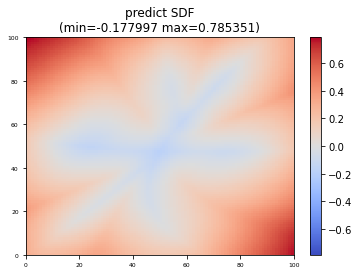

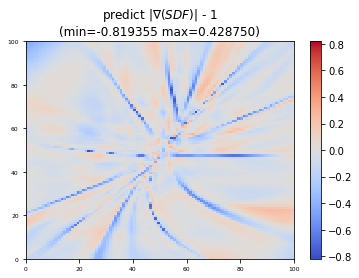

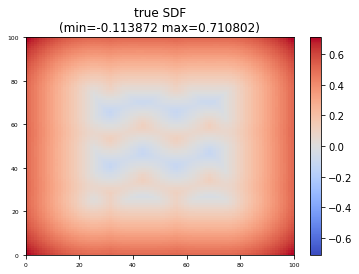

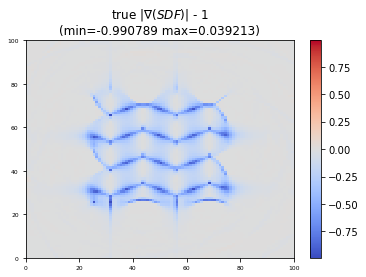

In [9]:
from utils import SDFVisualize, plot_model_weight
visualize = SDFVisualize(z_level=0, step=0.05, offset=30, nums=100, device=device)
visualize.from_nn(net, bounds_from_mesh=output_stl)
visualize.from_mesh(output_stl)